# Google Colab Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/DataScience/machine_learning/kaggle/Melbourne-Housing/

Mounted at /content/drive
[Errno 2] No such file or directory: '/content/drive/MyDrive/DataScience/machine_learning/kaggle/Melbourne-Housing/'
/content


In [ ]:
import os
# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Libraries

In [ ]:
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

# Data scaling
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# Evaluation
from sklearn.metrics import mean_squared_error

In [ ]:
# Libraries for custom Transformer
from sklearn.base import BaseEstimator, TransformerMixin

# Data Loading

In [ ]:
import pandas as pd
PATH = "dataset/melb_data.csv"

housing = pd.read_csv(PATH)

In [ ]:
housing.head(2)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0


In [ ]:
housing.shape

(13580, 21)

In [ ]:
housing.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount'],
      dtype='object')

In [ ]:
# X = housing.drop('Price', axis=1)
# # y = housing[['Price']]
# y = housing.Price

# Data Type 

In [ ]:
# First step: pass data to imputer and remove coloum
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13580 non-null  object 
 1   Address        13580 non-null  object 
 2   Rooms          13580 non-null  int64  
 3   Type           13580 non-null  object 
 4   Price          13580 non-null  float64
 5   Method         13580 non-null  object 
 6   SellerG        13580 non-null  object 
 7   Date           13580 non-null  object 
 8   Distance       13580 non-null  float64
 9   Postcode       13580 non-null  float64
 10  Bedroom2       13580 non-null  float64
 11  Bathroom       13580 non-null  float64
 12  Car            13518 non-null  float64
 13  Landsize       13580 non-null  float64
 14  BuildingArea   7130 non-null   float64
 15  YearBuilt      8205 non-null   float64
 16  CouncilArea    12211 non-null  object 
 17  Lattitude      13580 non-null  float64
 18  Longti

In [ ]:
# Classify numerical and categorical columns
num_cols = [col for col in housing.columns if housing[col].dtype in ['int64', 'float64']]
cat_cols = [col for col in housing.columns if housing[col].dtype in ['object']]
print('num_cols: ', num_cols)
print('cat_cols: ', cat_cols)
print()


card = [housing[cname].nunique() for cname in cat_cols]
for a,b in zip(cat_cols, card):
    print(a, b)
    
print()

# Cols with low cardinality
low_card_cols = [col for col in cat_cols if housing[col].nunique() < 10]
print('low_card_cols: ', low_card_cols)

high_card_cols = [col for col in cat_cols if housing[col].nunique() >= 10]
print('high_card_cols: ', high_card_cols)


# # Classify numerical and categorical columns
# num_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
# cat_cols = [col for col in X.columns if X[col].dtype in ['object']]
# print('num_cols: ', num_cols)
# print('cat_cols: ', cat_cols)
# print()


# card = [X[cname].nunique() for cname in cat_cols]
# for a,b in zip(cat_cols, card):
#     print(a, b)
    
# print()

# # Cols with low cardinality
# low_card_cols = [col for col in cat_cols if X[col].nunique() < 10]
# print('low_card_cols: ', low_card_cols)

# high_card_cols = [col for col in cat_cols if X[col].nunique() >= 10]
# print('high_card_cols: ', high_card_cols)

num_cols:  ['Rooms', 'Price', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']
cat_cols:  ['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea', 'Regionname']

Suburb 314
Address 13378
Type 3
Method 5
SellerG 268
Date 58
CouncilArea 33
Regionname 8

low_card_cols:  ['Type', 'Method', 'Regionname']
high_card_cols:  ['Suburb', 'Address', 'SellerG', 'Date', 'CouncilArea']


# Data Cleaning

## Remove Unwanted Columns

In [ ]:
# 1. Transfomer for deleting unwanted cols

# columns to be deleted
unwanted_cols = ['Date', 'Suburb', 'Address', 'SellerG', 'Postcode', 'haha']
# remaining cat_cols = ['Type', 'Method', 'CouncilArea', 'Regionname']

class RemoveUnwantedCatTrans(BaseEstimator, TransformerMixin):
    def __init__(self, cols = unwanted_cols):
        self.cols = cols
        pass
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
#         X_ = X.copy()
#         for col in self.cols:
#             if col in X_:
#                 X_ = X_.drop(col, axis=1, inplace=True)
        X_ = X.drop(self.cols, axis=1, errors='ignore')
#         print(X_)
        return X_

In [ ]:
# Update num_cols & cat_cols once determine which cols to be removed
for col in unwanted_cols:
    if col in num_cols:
        num_cols.remove(col)
    if col in cat_cols:
        cat_cols.remove(col)
    if col in high_card_cols:
        high_card_cols.remove(col)
    if col in low_card_cols:
        low_card_cols.remove(col)
        
print('After removing unwanted columns:')
print('num_cols: ', num_cols, len(num_cols))
print('cat_cols: ', cat_cols, len(cat_cols))
print('high_card_cols: ', high_card_cols, len(high_card_cols))
print('low_card_cols: ', low_card_cols, len(low_card_cols))

After removing unwanted columns:
num_cols:  ['Rooms', 'Price', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount'] 12
cat_cols:  ['Type', 'Method', 'CouncilArea', 'Regionname'] 4
high_card_cols:  ['CouncilArea'] 1
low_card_cols:  ['Type', 'Method', 'Regionname'] 3


## Parsing Date Trans

In [ ]:
# 2. Parsing Date Transformer

# index of columns to be deleted
date_cols = ['Date']

for col in date_cols:
    if col in cat_cols:
        cat_cols.remove(col)
print('cat_cols: ', cat_cols, len(cat_cols))

cat_cols:  ['Type', 'Method', 'CouncilArea', 'Regionname'] 4


In [ ]:
class ParseDateTrans(BaseEstimator, TransformerMixin):
    def __init__(self, cols = date_cols):
        self.cols = cols
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        X_ = X.copy()
        X_['ParsedDate'] = pd.to_datetime(X_['Date'], format="%d/%m/%y", infer_datetime_format=True)
        return X_.drop(self.cols, axis=1)

## Fill NaN Values

In [ ]:
imputer_col_trans = ColumnTransformer([
    ('imputer_num', SimpleImputer(strategy='median'), num_cols),
    ('imputer_col', SimpleImputer(strategy='most_frequent'), cat_cols)
])

## Pipeline

In [ ]:
# Removal & Parsing Date Pipeline!!!
clean_pipe = Pipeline(steps=[
    ('rmUnwanted', RemoveUnwantedCatTrans()),
    ('imputer', imputer_col_trans),
#     ('parseDate', ParseDateTrans())
])

In [ ]:
# Get X_cleaned after performing initial removing unwanted columns and imputing missing values

housing_cleaned = pd.DataFrame(clean_pipe.fit_transform(housing))
remaining_cols = num_cols + cat_cols
housing_cleaned.columns = remaining_cols

In [ ]:
housing_cleaned.head(2)

,Rooms,Price,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount,Type,Method,CouncilArea,Regionname
0,2.0,1480000.0,2.5,2.0,1.0,1.0,202.0,126.0,1970.0,-37.7996,144.9984,4019.0,h,S,Yarra,Northern Metropolitan
1,2.0,1035000.0,2.5,2.0,1.0,0.0,156.0,79.0,1900.0,-37.8079,144.9934,4019.0,h,S,Yarra,Northern Metropolitan


In [ ]:
housing_ = housing_cleaned[num_cols].astype('float64')
housing_cleaned = housing_.join(housing_cleaned[cat_cols])

In [ ]:
housing_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rooms          13580 non-null  float64
 1   Price          13580 non-null  float64
 2   Distance       13580 non-null  float64
 3   Bedroom2       13580 non-null  float64
 4   Bathroom       13580 non-null  float64
 5   Car            13580 non-null  float64
 6   Landsize       13580 non-null  float64
 7   BuildingArea   13580 non-null  float64
 8   YearBuilt      13580 non-null  float64
 9   Lattitude      13580 non-null  float64
 10  Longtitude     13580 non-null  float64
 11  Propertycount  13580 non-null  float64
 12  Type           13580 non-null  object 
 13  Method         13580 non-null  object 
 14  CouncilArea    13580 non-null  object 
 15  Regionname     13580 non-null  object 
dtypes: float64(12), object(4)
memory usage: 1.7+ MB


# Data Analysis

In [ ]:
housing_cleaned.describe()

,Rooms,Price,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,13580.000000,1.358000e+04,13580.000000,13580.000000,13580.000000,13580.000000,13580.000000,13580.000000,13580.000000,13580.000000,13580.000000,13580.000000
mean,2.937997,1.075684e+06,10.137776,2.914728,1.534242,1.611856,558.416127,139.633972,1966.788218,-37.809203,144.995216,7454.417378
std,0.955748,6.393107e+05,5.868725,0.965921,0.691712,0.960793,3990.669241,392.217403,29.088642,0.079260,0.103916,4378.581772
min,1.000000,8.500000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1196.000000,-38.182550,144.431810,249.000000
25%,2.000000,6.500000e+05,6.100000,2.000000,1.000000,1.000000,177.000000,122.000000,1960.000000,-37.856822,144.929600,4380.000000
50%,3.000000,9.030000e+05,9.200000,3.000000,1.000000,2.000000,440.000000,126.000000,1970.000000,-37.802355,145.000100,6555.000000
75%,3.000000,1.330000e+06,13.000000,3.000000,2.000000,2.000000,651.000000,129.940000,1975.000000,-37.756400,145.058305,10331.000000
max,10.000000,9.000000e+06,48.100000,20.000000,8.000000,10.000000,433014.000000,44515.000000,2018.000000,-37.408530,145.526350,21650.000000


In [ ]:
housing_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Rooms            13580 non-null  float64
 1   Price            13580 non-null  float64
 2   Distance         13580 non-null  float64
 3   Bedroom2         13580 non-null  float64
 4   Bathroom         13580 non-null  float64
 5   Car              13580 non-null  float64
 6   Landsize         13580 non-null  float64
 7   BuildingArea     13580 non-null  float64
 8   YearBuilt        13580 non-null  float64
 9   Lattitude        13580 non-null  float64
 10  Longtitude       13580 non-null  float64
 11  Propertycount    13580 non-null  float64
 12  Type             13580 non-null  object 
 13  Method           13580 non-null  object 
 14  CouncilArea      13580 non-null  object 
 15  Regionname       13580 non-null  object 
 16  CA_median_price  13580 non-null  float64
 17  RN_median_pr

In [ ]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

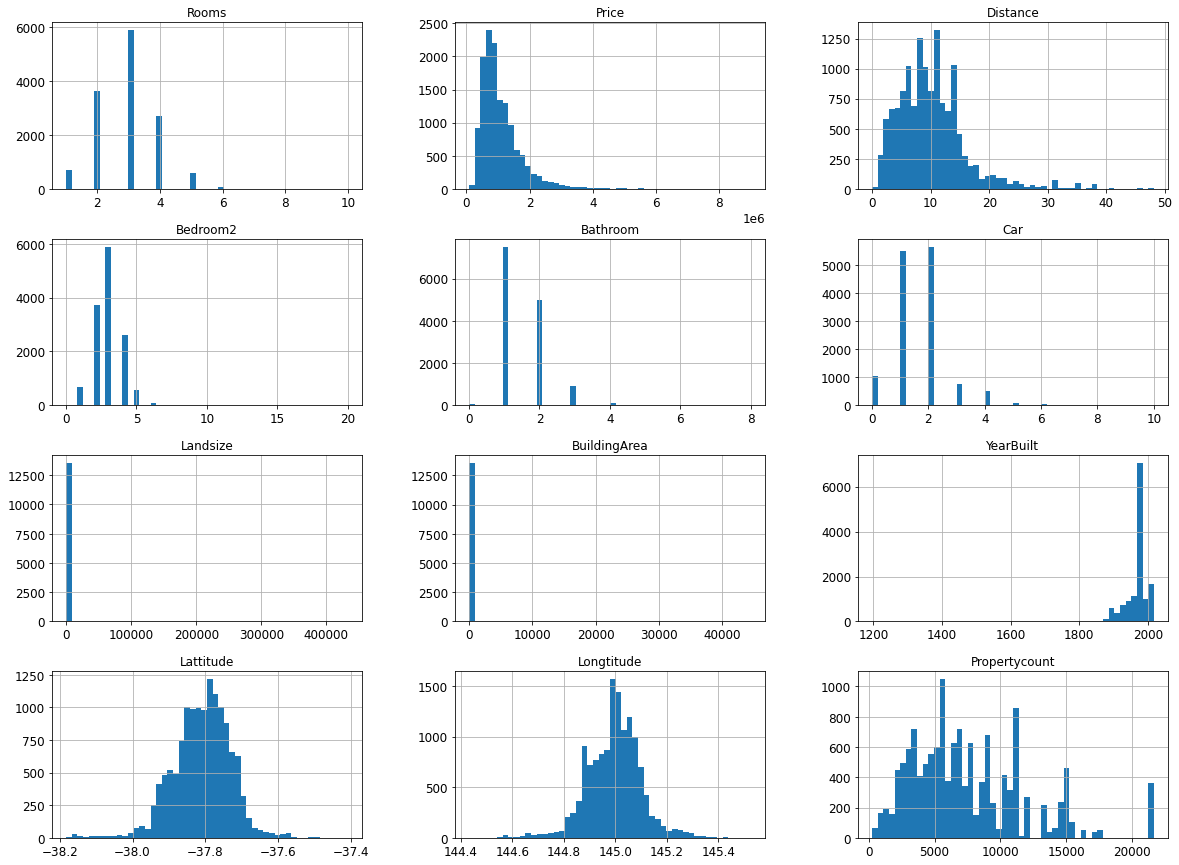

In [ ]:
housing_cleaned.hist(bins=50, figsize=(20, 15))
plt.show()

In [ ]:
# Graph of BuidingArea & Landsize seems weird because there are outliers having very large value
print(housing_cleaned.Landsize.head(10).median())
print(housing_cleaned.BuildingArea.head(10).median())

168.5
126.0


In [ ]:
max(housing_cleaned.Distance)

48.1

In [ ]:
# https://www.geeksforgeeks.org/matplotlib-pyplot-subplots-in-python/
def plot_quantile(data=None, q=0.1, ax=None, title=None, bins=20):
    # data is a dataFrame
    if ax == None:
        raise Exception('No axix "ax" is provided')
        
    low = data.quantile(0.05).values[0]
    high = data.quantile(0.95).values[0]

    ax.hist(data, bins=bins, range=(low, high))
    if title != None:
        ax.set_title(title)

In [ ]:
# Remove the outliers using quantiles and set x-axis range according to quantiles
fig, (ax1, ax2) = plt.subplots(1, 2)

plot_quantile(data=housing_cleaned[['Landsize']], q=0.05, ax=ax1, title='Landsize', bins=30)
plot_quantile(data=housing_cleaned[['BuildingArea']], q=0.05, ax=ax2, title='BuildingArea', bins=30)

fig.suptitle('Graphs With Outliers Removed')
fig.tight_layout()
plt.show()

In [ ]:
print('max_landsize: ', max(housing_cleaned.Landsize), 'min_landsize: ', min(housing_cleaned.Landsize))
# print('max_buildarea: ', max(housing.BuildingArea))

max_landsize:  433014.0 min_landsize:  0.0


## Visualizing Geographical Data

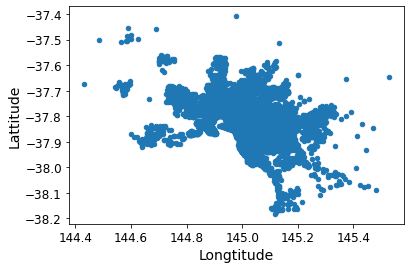

In [ ]:
housing_cleaned.plot(kind='scatter', x='Longtitude', y='Lattitude')
# save_fig('bad_geo_plot')

Saving figure better_geo_plot


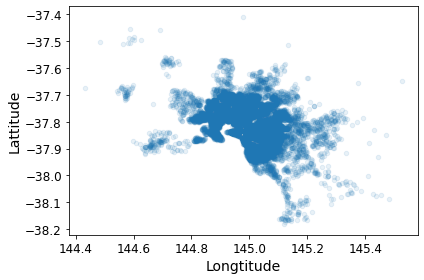

In [ ]:
housing_cleaned.plot(kind='scatter', x='Longtitude', y='Lattitude', alpha=0.1)
# save_fig('better_geo_plot')

In [ ]:
housing_cleaned.iloc[0]

Rooms                              2.0
Price                        1480000.0
Distance                           2.5
Bedroom2                           2.0
Bathroom                           1.0
Car                                1.0
Landsize                         202.0
BuildingArea                     126.0
YearBuilt                       1970.0
Lattitude                     -37.7996
Longtitude                    144.9984
Propertycount                   4019.0
Type                                 h
Method                               S
CouncilArea                      Yarra
Regionname       Northern Metropolitan
Name: 0, dtype: object

No handles with labels found to put in legend.


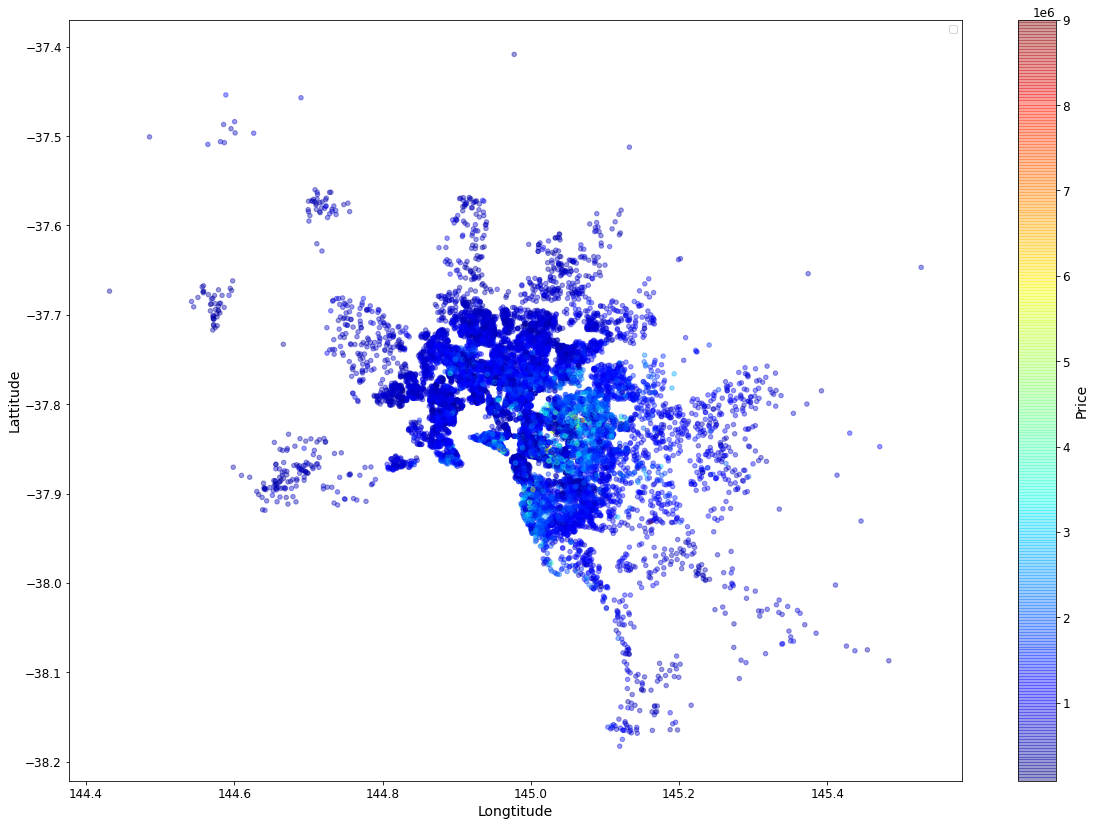

In [ ]:
housing_cleaned.plot(kind="scatter", x="Longtitude", y="Lattitude", alpha=0.4, figsize=(20,14),
             c="Price", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)

plt.legend()
# save_fig("housing_prices_scatterplot")

In [ ]:
housing_cleaned.head(2)

,Rooms,Price,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount,Type,Method,CouncilArea,Regionname
0,2.0,1480000.0,2.5,2.0,1.0,1.0,202.0,126.0,1970.0,-37.7996,144.9984,4019.0,h,S,Yarra,Northern Metropolitan
1,2.0,1035000.0,2.5,2.0,1.0,0.0,156.0,79.0,1900.0,-37.8079,144.9934,4019.0,h,S,Yarra,Northern Metropolitan


In [ ]:
ordinal_encoder = OrdinalEncoder()
regionname_encoded = ordinal_encoder.fit_transform(housing_cleaned[['Regionname']])

# Remember to turn result of ordinal encoder to a DataFrame object
regionname_encoded = pd.DataFrame(regionname_encoded, columns=['Regionname_encoded'])

In [ ]:
# UNDER TESTING
# Objective: plot all data on map group by their regionname: assign the same 
# color to data point within the region --> to see the distribution

'''
ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not ['Northern Metropolitan' 'Northern Metropolitan' 'Northern Metropolitan'
 ... 'Western Metropolitan' 'Western Metropolitan' 'Western Metropolitan']
'''
housing_cleaned.plot(kind="scatter", x="Longtitude", y="Lattitude", alpha=0.4, figsize=(10,7),
             c="Regionname", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()

## Correlations

In [ ]:
corr_matrix = housing_cleaned.corr()

In [ ]:
corr_matrix['Price'].sort_values(ascending=False)

Price            1.000000
Rooms            0.496634
Bedroom2         0.475951
Bathroom         0.467038
Car              0.239109
Longtitude       0.203656
BuildingArea     0.069763
Landsize         0.037507
Propertycount   -0.042153
Distance        -0.162522
Lattitude       -0.212934
YearBuilt       -0.259387
Name: Price, dtype: float64

In [ ]:
cat_cols

['Type', 'Method', 'CouncilArea', 'Regionname']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1403fb2cd0>,
      dtype=object)

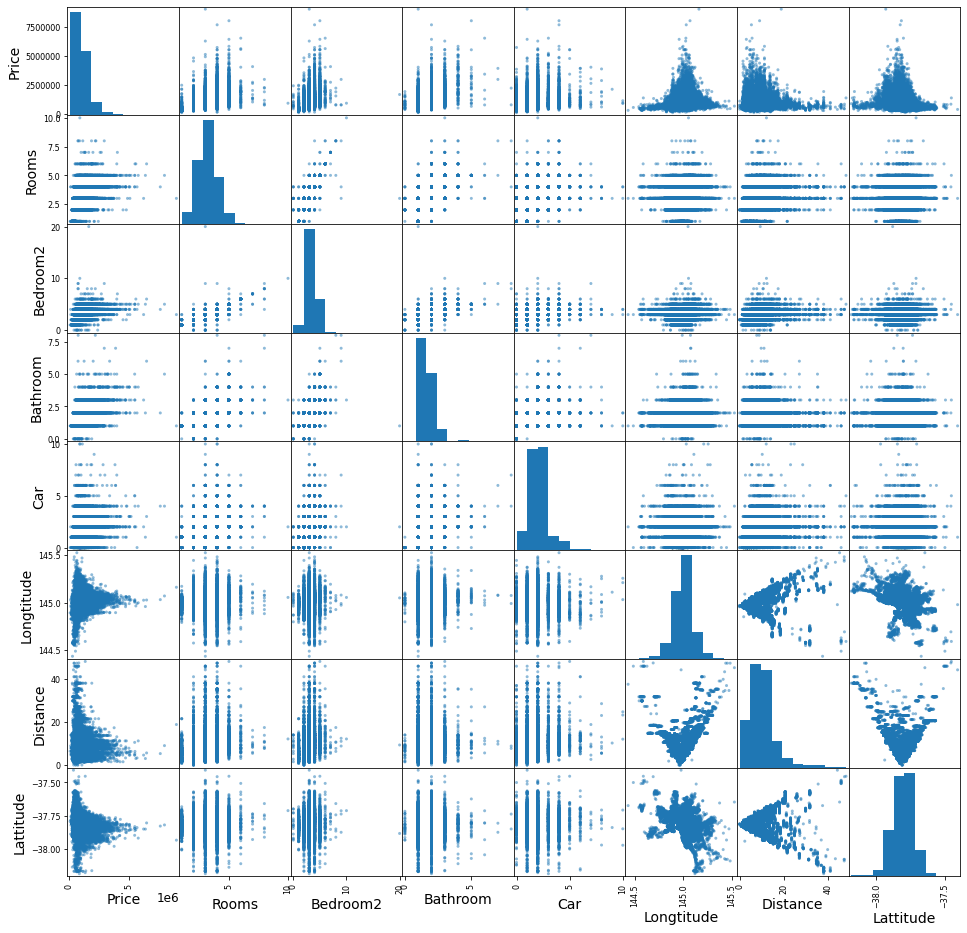

In [ ]:
# Plot a series of correlation graph which shows the linear relationship between 
# any 2 features with high correlation observed from the above corr_matrix['Price']

from pandas.plotting import scatter_matrix

attributes = ['Price', 'Rooms', 'Bedroom2', 
              'Bathroom', 'Car', 'Longtitude', 
              'Distance', 'Lattitude']

scatter_matrix(housing_cleaned[attributes], figsize=(16, 16))
# save_fig('scatter_matrix_plot')

In [ ]:
print(cat_cols)
print(housing_cleaned.CouncilArea.nunique())
print(housing_cleaned.Regionname.nunique())

['Type', 'Method', 'CouncilArea', 'Regionname']
33
8


In [ ]:
# Group housing data by councilArea and Regionname
# Investigate price pattern comparing different districts

housing_cleaned['CA_median_price'] = (housing_cleaned.groupby("CouncilArea")["Price"].transform("median"))
housing_cleaned['RN_median_price'] = (housing_cleaned.groupby('Regionname')['Price'].transform('median'))

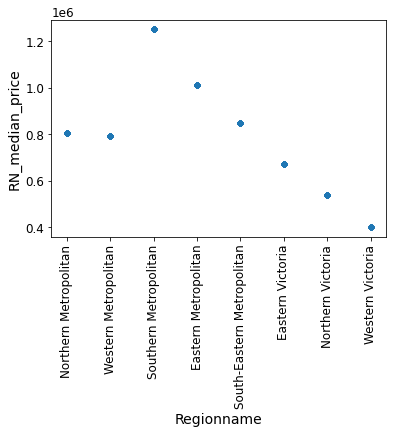

In [ ]:
housing_cleaned.plot(kind='scatter', x='Regionname', y='RN_median_price', rot=90)

# Alternative Method: to be investigated!!!!!
# Draw a bar chart: Regionname against Price
# housing_cleaned.plot(kind='bar', x='Regionname', y='RN')
# housing_cleaned.plot.bar(x='Regionname', y='RN')

In [ ]:
housing_cleaned.drop(['CA_median_price', 'RN_median_price'], axis=1, inplace=True)

## Mutual Information (MI)

In [ ]:
from sklearn.feature_selection import mutual_info_regression

# Find the MI between the target and each features
def make_mi_scores(X, y, discrete_features):
    # Only plug in discrete features
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    # Make a pandas series to store the result
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [ ]:
# Label encoding for categoricals
for colname in housing_cleaned.select_dtypes(exclude=["float64"]):
    housing_cleaned[colname], _ = housing_cleaned[colname].factorize()

discrete_features = housing_cleaned.dtypes
mi_scores = make_mi_scores(housing_cleaned.drop(['Price'], axis=1), housing_cleaned.Price, discrete_features)
mi_scores[::3]  # show a few features with their MI scores

TypeError: ignored

## Experimenting with Attribute Combinations

In [ ]:
# Examples of combined attributes:

# housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
# housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
# housing["population_per_household"]=housing["population"]/housing["households"]

# Data Split

## StratifiedShuffleSplit

In [ ]:
# Observe that 'Distance' feature has a typical distribution
# we can consider split using the idea of different classes

housing_cleaned['dist_cat'] = pd.cut(
    housing_cleaned['Distance'], 
    bins=[-1.0, 6., 12., 18., 24., np.inf], 
    labels=[1, 2, 3, 4, 5]
)

# housing["income_cat"] = pd.cut(housing["median_income"],
#                                bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
#                                labels=[1, 2, 3, 4, 5])

In [ ]:
housing_cleaned.drop('dist_cat', inplace=True, axis=1)

In [ ]:
housing_cleaned.head(2)

,Rooms,Price,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount,Type,Method,CouncilArea,Regionname,CA_median_price,RN_median_price
0,2.0,1480000.0,2.5,2.0,1.0,1.0,202.0,126.0,1970.0,-37.7996,144.9984,4019.0,h,S,Yarra,Northern Metropolitan,1090000.0,806250.0
1,2.0,1035000.0,2.5,2.0,1.0,0.0,156.0,79.0,1900.0,-37.8079,144.9934,4019.0,h,S,Yarra,Northern Metropolitan,1090000.0,806250.0


In [ ]:
housing_cleaned.dist_cat.value_counts()

2    6230
1    3260
3    3169
4     522
5     399
Name: dist_cat, dtype: int64

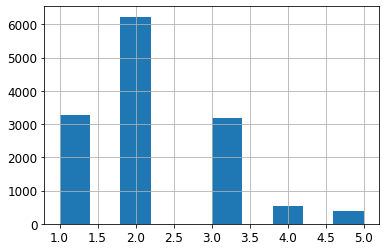

In [ ]:
housing_cleaned.dist_cat.hist()

In [ ]:
housing_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Rooms          13580 non-null  float64 
 1   Price          13580 non-null  float64 
 2   Distance       13580 non-null  float64 
 3   Bedroom2       13580 non-null  float64 
 4   Bathroom       13580 non-null  float64 
 5   Car            13580 non-null  float64 
 6   Landsize       13580 non-null  float64 
 7   BuildingArea   13580 non-null  float64 
 8   YearBuilt      13580 non-null  float64 
 9   Lattitude      13580 non-null  float64 
 10  Longtitude     13580 non-null  float64 
 11  Propertycount  13580 non-null  float64 
 12  Type           13580 non-null  object  
 13  Method         13580 non-null  object  
 14  CouncilArea    13580 non-null  object  
 15  Regionname     13580 non-null  object  
 16  dist_cat       13580 non-null  category
dtypes: category(1), float64(12), ob

In [ ]:
sample_incomplete_rows = housing_cleaned[housing_cleaned.isnull().any(axis=1)]
sample_incomplete_rows

# Finally there are no rows containing null values

,Rooms,Price,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount,Type,Method,CouncilArea,Regionname,dist_cat


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing_cleaned, housing_cleaned["dist_cat"]):
    strat_train_set = housing_cleaned.loc[train_index]
    strat_test_set = housing_cleaned.loc[test_index]

In [ ]:
strat_train_set.dist_cat.value_counts() / len(housing_cleaned)

2    0.367010
1    0.192047
3    0.186672
4    0.030781
5    0.023490
Name: dist_cat, dtype: float64

In [ ]:
housing_cleaned.dist_cat.value_counts() / len(housing_cleaned)

2    0.458763
1    0.240059
3    0.233358
4    0.038439
5    0.029381
Name: dist_cat, dtype: float64

In [ ]:
print(len(strat_train_set))
print(len(strat_test_set))

10864
2716


In [ ]:
# Drop 'dist_cat' column since it will be used anymore
strat_train_set.drop(['dist_cat'], inplace=True, axis=1)
strat_test_set.drop(['dist_cat'], inplace=True, axis=1)

In [ ]:
# Saparate labels from features in stratified dataset
y_train = strat_train_set.Price
X_train = strat_train_set.drop(['Price'], axis=1)

y_test = strat_test_set.Price
X_test = strat_test_set.drop(['Price'], axis=1)

# from sklearn.model_selection import train_test_split
# # Seperate housing data into features and labels
# y = housing.Price
# X = housing.drop(['Price'], axis=1)
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

# Transformer

## Categorical Trans

### High Card Trans

In [ ]:
# High Cardinality Transformer: perform one-hot transformer for high-cardinality
# columns while avoiding generating too much dummpy features. It will only one-hot
# the classes with high proportion. A threshold can be set.

from collections import Counter

def cumulatively_categorise(column,threshold=0.75,return_categories_list=True):
    #Find the threshold value using the percentage and number of instances in the column
    threshold_value=int(threshold*len(column))
    #Initialise an empty list for our new minimised categories
    categories_list=[]
    #Initialise a variable to calculate the sum of frequencies
    s=0
    #Create a counter dictionary of the form unique_value: frequency
    counts=Counter(column)

    #Loop through the category name and its corresponding frequency after sorting the categories by descending order of frequency
    for i,j in counts.most_common():
        #Add the frequency to the global sum
        s+=dict(counts)[i]
        #Append the category name to the list
        categories_list.append(i)
        #Check if the global sum has reached the threshold value, if so break the loop
        if s>=threshold_value:
            break
    #Append the category Other to the list
    categories_list.append('Other')

    #Replace all instances not in our new categories by Other  
    new_column=column.apply(lambda x: x if x in categories_list else 'Other')

    #Return transformed column and unique values if return_categories=True
    if(return_categories_list):
        return new_column,categories_list
    #Return only the transformed column if return_categories=False
    else:
        return new_column

In [ ]:
# high_card_cols = ['Regionname', 'CouncilArea']
class HighCardAggregation(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.cols = high_card_cols
        pass

    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
        # X is a numpy array, the columns to with high cardinality
        X_ = X.copy()
        X_df = pd.DataFrame(X, columns=high_card_cols)
        
        for col in self.cols:
            # transformed_columns is a pandas dataframe
            transformed_column, trans_list = cumulatively_categorise(column=X_df[col], threshold=0.75)
#             print('transformed_column: \n', transformed_column.value_counts())
            X_ = np.c_[X_, transformed_column.to_numpy()]
            
        X_ = np.delete(X_, [i for i in range(len(self.cols))], 1)
        return X_

# Pipeline

In [ ]:
low_card_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

high_card_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('aggregation', HighCardAggregation()),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Numerical transformer
num_trans = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

# Categorical transformers
cat_trans = ColumnTransformer(transformers=[
    ('low_card_pipeline', low_card_pipe, low_card_cols),
    ('high_card_pipeline', high_card_pipe, high_card_cols)
])

# # Removal & Parsing Date Pipeline!!!
# clean_pipe = Pipeline(steps=[
#     ('rmUnwanted', RemoveUnwantedCatTrans()),
#     ('imputer', imputer_col_trans),
# #     ('parseDate', ParseDateTrans())
# ])

num_cat_col_trans = ColumnTransformer(transformers=[
    ('num', num_trans, num_cols),
    ('cat', cat_trans, cat_cols)
])

preprocessor = Pipeline([
    ('cleaning', clean_pipe),
    ('num_cat', num_cat_col_trans)
])

'''
# !!!Use the full pipeline when model are ready to deploy or use!!!
# full_pipeline = Pipeline([
#     ('preprocessor', preprocessor),
# #     ('model', LinearRegression())
#     ('model', RandomForestRegressor(n_estimators=50, random_state=42))
# ])
'''

# Testing

In [ ]:
data_prepared = preprocessor.fit_transform(X_train)
data_prepared[0]

In [ ]:
data_prepared[0].shape

In [ ]:
# # remaining cat_cols = ['Type', 'Method', 'Regionname', 'CouncilArea']
# 11 + 3 + 5 + 8 + 12 = 39

# data_prepared.shape: (10864, 39)

In [ ]:
# Just for testing!!!!!

onehot = OneHotEncoder()
cols = ['CouncilArea']
t2 = ColumnTransformer(transformers=[
#     ('low_card_pipeline', low_card_pipe, cols),
    ('high_card_pipeline', high_card_pipe, cols)
])

t1 = ColumnTransformer(transformers=[
    ('2', t2, cols)
])

p = Pipeline([
    ('1', t1)
])

p_prepared = p.fit_transform(X_train)
p_prepared[0].shape

# Model

## Load Model

In [ ]:
import joblib
import os
if os.path.isfile('models/forest_reg.pkl'):
    global forest_reg
    forest_reg = joblib.load('models/forest_reg.pkl')
    print('Load Successfull!')
#     global lin_reg = joblib.load('models/lin_reg.pkl')

## General

In [ ]:
# full_pipeline.fit(X_train, y_train)

In [ ]:
# y_pred = full_pipeline.predict(X_valid)

## Linear Regression

In [ ]:
# full_pipeline.fit(X_train, y_train)

In [ ]:
# y_pred = full_pipeline.predict(X_valid)

## Random Forest Regression 

In [ ]:
# V1 model has been saved to /models

# X_train_prepared = preprocessor.fit_transform(X_train)
# forest_reg = RandomForestRegressor(n_estimators=50, random_state=42)
# forest_reg.fit(X_train_prepared, y_train)

In [ ]:
# X_valid_prepared = preprocessor.transform(X_valid)
# y_pred = forest_reg.predict(X_valid_prepared)

## Saving Models 

In [ ]:
joblib.dump(forest_reg, 'models/forest_reg.pkl')
# joblib.dump(lin_reg, 'models/lin_reg.pkl')

# Evaluation

In [ ]:
for a,b, c in zip(y_valid.index[:10], y_valid[:10], y_pred):
    print(a, ' ', b, ' ', c)

In [ ]:
forest_rmse = mean_squared_error(y_pred, y_valid, squared=False)
forest_rmse